In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
!pip install matplotlib

In [9]:
def preprocessing():
    #reading the csv file
    df = pd.read_csv('CUACA MALANG 2000-2021.csv')
    #dropping unnecessary columns
    df = df.drop(['Tn','Tx','ff_x','ddd_x','ff_avg','ddd_car'], axis =1)
    #adjusting the date columns
    from datetime import date,timedelta
    datedata = []
    start_yr, start_mo, start_dd = 2000, 1, 1
    end_yr, end_mo, end_dd = 2021,12,31
    start_date = date(start_yr, start_mo, start_dd) 
    end_date = date(end_yr, end_mo, end_dd) 
    delta = end_date - start_date 
    for i in range(delta.days + 1):
        day = start_date + timedelta(days=i)
        datedata.append(day)
    df['Date'] = datedata
    df['YR'] = [d.year for d in df['Date']]
    df['MO'] = [d.month for d in df['Date']]
    df['DD'] = [d.day for d in df['Date']]
    #filling null values in each column with interpolation values
    df['Tavg'] = df['Tavg'].interpolate()
    df['RH_avg'] = df['RH_avg'].interpolate()
    df['ss'] = df['ss'].interpolate()
    df['RR'] = df['RR'].fillna(0)
    import warnings
    warnings.filterwarnings('ignore')
    for index, value in enumerate(df['RR']):
        if value == 8888:
            df['RR'][index] = np.nan
        elif value == 9999:
            df['RR'][index] = np.nan
    df['RR'] = df['RR'].interpolate()
    df = df[['Date', 'YR','MO','DD','Tavg','RH_avg','RR','ss']]
    return df

In [57]:
df = pd.read_csv('new weather with rain_prob')
df = df.drop(['Unnamed: 0'],axis =1)
df.head().to_clipboard()

In [58]:
from sklearn.preprocessing import MinMaxScaler
df_cl = df[['Tavg','RH_avg','ss']]
collist = df_cl.columns.tolist()
scaler= MinMaxScaler()
scaler.fit(df_cl)

MinMaxScaler()

In [59]:
df_cl

,Tavg,RH_avg,ss
0,25.1,82.0,6.7
1,25.1,81.0,6.3
2,25.6,82.0,5.9
3,24.8,88.0,5.7
4,25.6,79.0,6.2
...,...,...,...
2277,23.2,88.0,1.6
2278,23.8,82.0,0.7
2279,23.8,84.0,7.5
2280,24.8,79.0,4.7


In [60]:
#importing dependencies
from sklearn.preprocessing import MinMaxScaler
#calling the columns for scaling
df_cl = df[['Tavg','RH_avg','ss']]
collist = df_cl.columns.tolist()
#calling and fitting the scaler to the dataset
scaler= MinMaxScaler()
scaler.fit(df_cl)
#tramsforming the dataset using the scaler
df_cl_v = scaler.transform(df_cl)
scaled_dataframe = pd.DataFrame()
#create dataframe with rain probability
for i in range(len(collist)):
    scaled_dataframe[collist[i]] = df_cl_v[:,i]
scaled_dataframe['Rain_prob'] = df['Rain_probability']
scaled_dataframe

,Tavg,RH_avg,ss,Rain_prob
0,0.723684,0.758621,0.609091,0.484436
1,0.723684,0.741379,0.572727,0.482802
2,0.789474,0.758621,0.536364,0.552218
3,0.684211,0.862069,0.518182,0.756321
4,0.789474,0.706897,0.563636,0.420717
...,...,...,...,...
2277,0.473684,0.862069,0.145455,0.925957
2278,0.552632,0.758621,0.063636,0.878370
2279,0.552632,0.793103,0.681818,0.487705
2280,0.684211,0.706897,0.427273,0.547360


In [61]:
scaled_dataframe.to_clipboard()

In [62]:
from sklearn.cluster import KMeans
class KMeansInterp(KMeans):
    def __init__(self, ordered_feature_names, feature_importance_method='wcss_min', **kwargs):
        super(KMeansInterp, self).__init__(**kwargs)
        self.feature_importance_method = feature_importance_method
        self.ordered_feature_names = ordered_feature_names
        
    def fit(self, X, y=None, sample_weight=None):
        super().fit(X=X, y=y, sample_weight=sample_weight)
        
        if not len(self.ordered_feature_names) == self.n_features_in_:
            raise Exception(f"Model is fitted on {self.n_features_in_} but ordered_feature_names = {len(self.ordered_feature_names)}")
        
        if self.feature_importance_method == "wcss_min":
            self.feature_importances_ = self.get_feature_imp_wcss_min()
        elif self.feature_importance_method == "unsup2sup":
            self.feature_importances_ = self.get_feature_imp_unsup2sup(X)
        else: 
            raise Exception(f" {self.feature_importance_method}"+\
            "is not available. Please choose from  ['wcss_min' , 'unsup2sup']")
        
        return self
        
    def get_feature_imp_wcss_min(self):
        labels = self.n_clusters
        centroids = self.cluster_centers_
        centroids = np.vectorize(lambda x: np.abs(x))(centroids)
        sorted_centroid_features_idx = centroids.argsort(axis=1)[:,::-1]

        cluster_feature_weights = {}
        for label, centroid in zip(range(labels), sorted_centroid_features_idx):
            ordered_cluster_feature_weights = centroids[label][sorted_centroid_features_idx[label]]
            ordered_cluster_features = [self.ordered_feature_names[feature] for feature in centroid]
            cluster_feature_weights[label] = list(zip(ordered_cluster_features, 
                                                      ordered_cluster_feature_weights))
        
        return cluster_feature_weights
    
    def get_feature_imp_unsup2sup(self, X):
        try:
            from sklearn.ensemble import RandomForestClassifier
        except ImportError as IE:
            print(IE.__class__.__name__ + ": " + IE.message)
            raise Exception("Please install scikit-learn. " + 
                            "'unsup2sup' method requires using a classifier"+ 
                            "and depends on 'sklearn.ensemble.RandomForestClassifier'")
        
        cluster_feature_weights = {}
        for label in range(self.n_clusters):
            binary_enc = np.vectorize(lambda x: 1 if x == label else 0)(self.labels_)
            clf = RandomForestClassifier()
            clf.fit(X, binary_enc)

            sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1]
            ordered_cluster_features = np.take_along_axis(
                np.array(self.ordered_feature_names), 
                sorted_feature_weight_idxes, 
                axis=0)
            ordered_cluster_feature_weights = np.take_along_axis(
                np.array(clf.feature_importances_), 
                sorted_feature_weight_idxes, 
                axis=0)
            cluster_feature_weights[label] = list(zip(ordered_cluster_features, 
                                                      ordered_cluster_feature_weights))
        return cluster_feature_weights

In [63]:
km = KMeansInterp(n_clusters=4,
                  ordered_feature_names=scaled_dataframe.columns.tolist(),
                  feature_importance_method='wcss_min',)
km.fit(scaled_dataframe)
imp_feature = km.feature_importances_ 

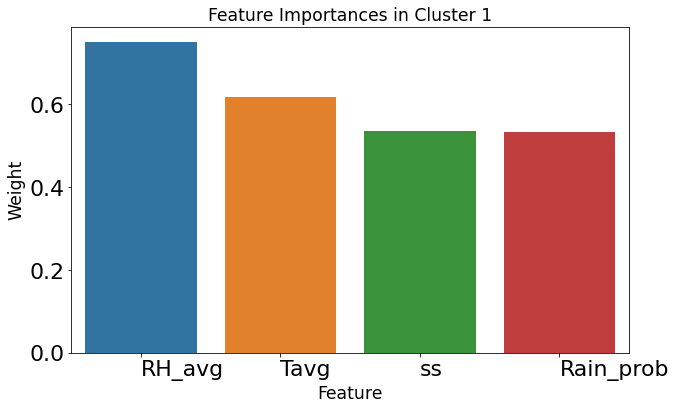

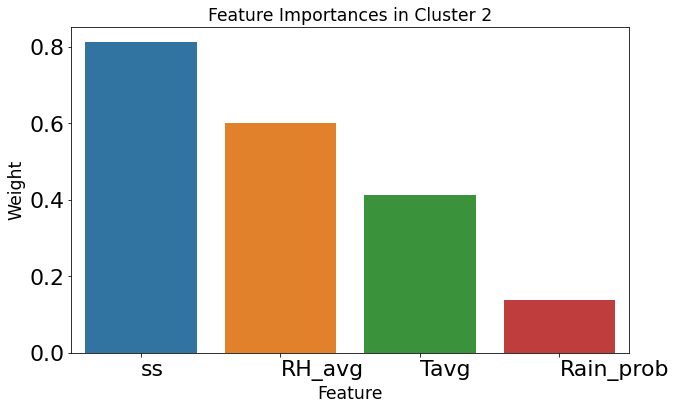

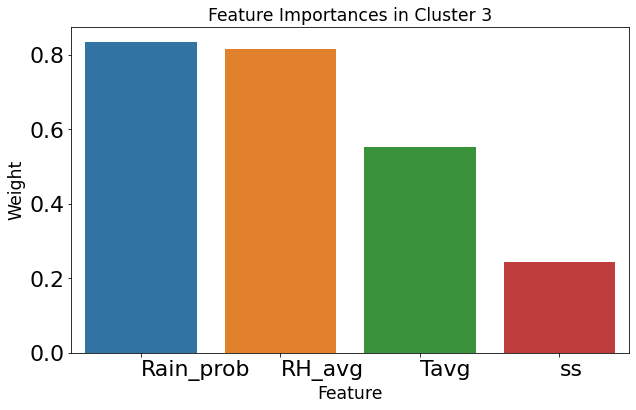

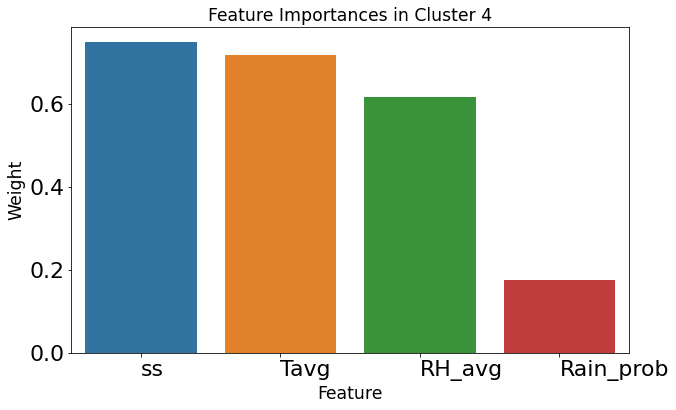

In [64]:
for cluster_label, features in imp_feature.items():
    df_feature_weight = pd.DataFrame(features,columns=["Feature", "Weight"])
    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(x="Feature", y="Weight", data=df_feature_weight)
    plt.xticks(ha="left");
    ax.tick_params(axis='both', which='major', labelsize=22)
    plt.title(f'Feature Importances in Cluster {cluster_label+1}', fontsize='xx-large')
    plt.xlabel('Feature', fontsize='xx-large')
    plt.ylabel('Weight', fontsize='xx-large')

    plt.show()

In [72]:
wtr_cl = km.predict(scaled_dataframe)
df['Clusters'] = wtr_cl
df_1 = df[df['Clusters'] == 0]
df_2 = df[df['Clusters'] == 1]
df_3 = df[df['Clusters'] == 2]
df_4 = df[df['Clusters'] == 3]

In [73]:
!pip3 show matplotlib

Name: matplotlib
Version: 3.5.2
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: c:\users\diki\appdata\roaming\python\python38\site-packages
Requires: cycler, kiwisolver, pyparsing, numpy, fonttools, pillow, packaging, python-dateutil
Required-by: torch-lr-finder, seaborn, scikit-image, neuralprophet


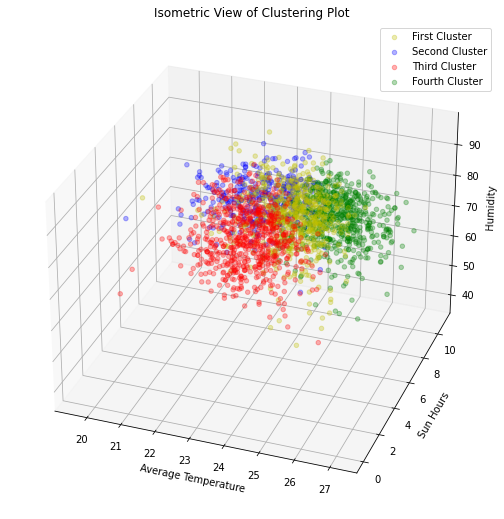

In [110]:
fig = plt.figure(figsize = (9,9))
ax = plt.axes(projection='3d')
ax.scatter(df_1['Tavg'], df_1['ss'], df_1['RH_avg'], c= 'y', label = 'First Cluster' ,alpha = 0.3)
ax.scatter(df_2['Tavg'], df_2['ss'], df_2['RH_avg'], c= 'b', label = 'Second Cluster' ,alpha = 0.3)
ax.scatter(df_3['Tavg'], df_3['ss'], df_3['RH_avg'], c= 'r', label = 'Third Cluster' ,alpha = 0.3)
ax.scatter(df_4['Tavg'], df_4['ss'], df_4['RH_avg'], c= 'g', label = 'Fourth Cluster' ,alpha = 0.3)
ax.set_xlabel('Average Temperature')
ax.set_ylabel('Sun Hours')
ax.set_zlabel('Humidity')
ax.set_title('Isometric View of Clustering Plot')
ax.azim = -70
ax.elev = 30
ax.legend()

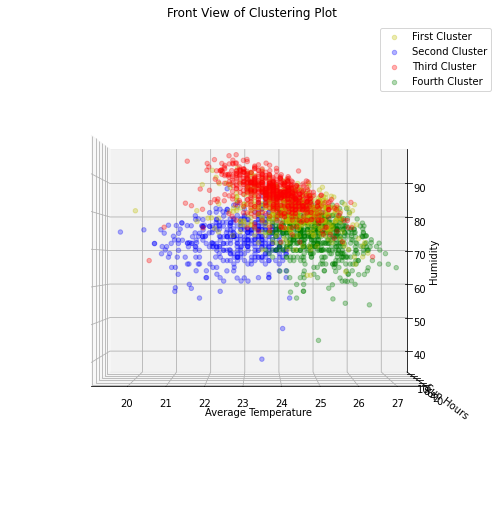

In [112]:
fig = plt.figure(figsize = (9,9))
ax = plt.axes(projection='3d')
ax.view_init(15,0)
ax.scatter(df_1['Tavg'], df_1['ss'], df_1['RH_avg'], c= 'y', label = 'First Cluster' ,alpha = 0.3)
ax.scatter(df_2['Tavg'], df_2['ss'], df_2['RH_avg'], c= 'b', label = 'Second Cluster' ,alpha = 0.3)
ax.scatter(df_3['Tavg'], df_3['ss'], df_3['RH_avg'], c= 'r', label = 'Third Cluster' ,alpha = 0.3)
ax.scatter(df_4['Tavg'], df_4['ss'], df_4['RH_avg'], c= 'g', label = 'Fourth Cluster' ,alpha = 0.3)
ax.set_xlabel('Average Temperature')
ax.set_ylabel('Sun Hours')
ax.set_zlabel('Humidity')
ax.set_title('Front View of Clustering Plot')
ax.azim = -90
ax.elev = 0
ax.legend()

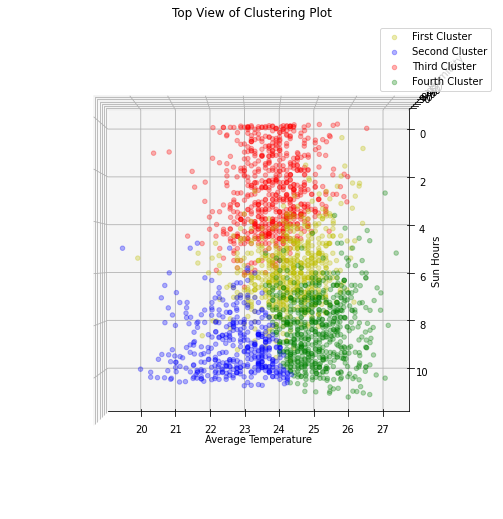

In [113]:
fig = plt.figure(figsize = (9,9))
ax = plt.axes(projection='3d')
ax.view_init(15,0)
ax.scatter(df_1['Tavg'], df_1['ss'], df_1['RH_avg'], c= 'y', label = 'First Cluster' ,alpha = 0.3)
ax.scatter(df_2['Tavg'], df_2['ss'], df_2['RH_avg'], c= 'b', label = 'Second Cluster' ,alpha = 0.3)
ax.scatter(df_3['Tavg'], df_3['ss'], df_3['RH_avg'], c= 'r', label = 'Third Cluster' ,alpha = 0.3)
ax.scatter(df_4['Tavg'], df_4['ss'], df_4['RH_avg'], c= 'g', label = 'Fourth Cluster' ,alpha = 0.3)
ax.set_xlabel('Average Temperature')
ax.set_ylabel('Sun Hours')
ax.set_zlabel('Humidity')
ax.set_title('Top View of Clustering Plot')
ax.azim = -90
ax.elev = -90
ax.legend()

In [115]:
cclass = []
for i in df['Clusters']:
    if i == 0:
        cclass.append('Mildly Cloudy with Moderate Probability of Rain')
    elif i == 1:
        cclass.append('Sunny and chill weather')
    elif i == 2:
        cclass.append('Cloudy with a high chance of rain')
    else:
        cclass.append('Relatively Sunny and Warm')
df['Weather State'] = cclass
df

,Date,YR,MO,DD,Tavg,RH_avg,RR,ss,Rainfall,Rain_probability,Clusters,Weather State
0,2016-01-01,2016,1,1,25.1,82.0,11.8,6.7,1,0.484436,0,Mildly Cloudy with Moderate Probability of Rain
1,2016-01-02,2016,1,2,25.1,81.0,3.5,6.3,1,0.482802,0,Mildly Cloudy with Moderate Probability of Rain
2,2016-01-03,2016,1,3,25.6,82.0,22.8,5.9,1,0.552218,0,Mildly Cloudy with Moderate Probability of Rain
3,2016-01-04,2016,1,4,24.8,88.0,11.5,5.7,1,0.756321,0,Mildly Cloudy with Moderate Probability of Rain
4,2016-01-05,2016,1,5,25.6,79.0,0.0,6.2,0,0.420717,0,Mildly Cloudy with Moderate Probability of Rain
...,...,...,...,...,...,...,...,...,...,...,...,...
2277,2022-03-27,2022,3,27,23.2,88.0,3.0,1.6,1,0.925957,2,Cloudy with a high chance of rain
2278,2022-03-28,2022,3,28,23.8,82.0,4.7,0.7,1,0.878370,2,Cloudy with a high chance of rain
2279,2022-03-29,2022,3,29,23.8,84.0,5.0,7.5,1,0.487705,0,Mildly Cloudy with Moderate Probability of Rain
2280,2022-03-30,2022,3,30,24.8,79.0,3.4,4.7,1,0.547360,0,Mildly Cloudy with Moderate Probability of Rain


In [116]:
import pickle
pickle.dump(km,open('Weather Classifier', 'wb'))

In [117]:
import pickle
pickle.dump(scaler,open('Weather Scaler','wb'))

In [118]:
df.to_csv('Clustered_csv')